# Machine Learning Algorithms

## 1. Gaussian mixture models

### Gaussian Mixture
- A probabilistic, parametric model that assumes data points are generated from a mixture of Gaussian distributions with unknown parameters 
- *Like* a generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians
- Expectation-maximization (EM) algorithm used for fitting mixtures. It can also draw confidence ellipsoids for multivariate models, and compute the BIC to assess the number of clusters in the data
 - EM: one assumes random components (randomly centered, learned from k-means, normally distributed etc.) and computes for each point a probability of being generated by each component of the model. 
 - Tweak the parameters to maximize the likelihood of the data given those assignments. Repeating this process is guaranteed to always converge to a local optimum
- Selection of the algorithm is done via BIC criterion. In theory, it recovers the true number of components only in the asymptotic regime (i.e. lot of data and generated  independent and identically distributed (i.i.d.)

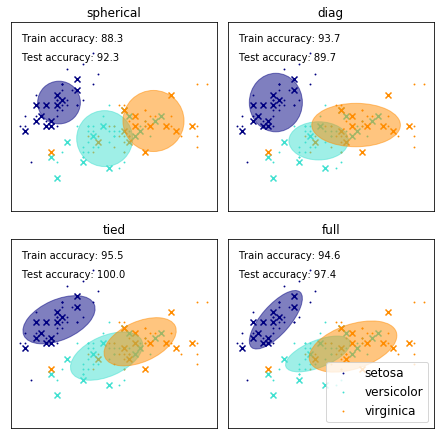

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ['navy', 'turquoise', 'darkorange']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

# Split training (75%) and testing (25%) sets
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))

X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = dict((cov_type, GaussianMixture(n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()): # fit for each type of covariance
    
    # Initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))

plt.show()

##### Advantages
- It is the fastest algorithm for learning mixture models
- As this algorithm maximizes only the likelihood, it will not bias the means towards zero, or bias the cluster sizes to have specific structures that might or might not apply

##### Disadvantages
- When one has insufficiently many points per mixture, estimating the covariance matrices becomes difficult - can diverge and find solutions with infinite likelihood, unless one regularizes the covariances artificially
- Not really 'unsupervised', requires validation data or information theoretical criteria to decide how many components

### Variational Bayesian Gaussian Mixture
- VBG mixtures avoids the specification requirement of the number of components
- VBG's algo is just EM, but applies regularization by integrating information from prior distributions. This avoids the singularities often found in EMs, but introduces some biases and is slower
- Also requires more parameters

In figure below helps exmine the Variational Inference (Dirichlet process prior) and EM (incorrectly specifed impact)
- Both models have access to 5 components to fit the data using. EM is trying to use all of it 
- While Variational Inference only uses required amount 

*Dirichlet process is a prior probability distribution on clusterings with an infinite, unbounded, number of partitions. Simply put, we retrieve the probability of all possible assignments for a large number of distributions. For more info; http://phyletica.org/dirichlet-process/*

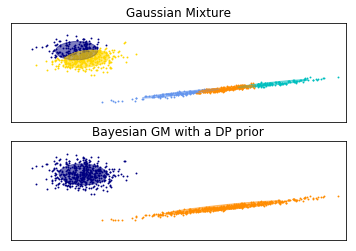

In [18]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])] # 2D array of scatter data

n_components = 5  # experiment with components

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=n_components, covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1, 'Bayesian GM with a DP prior')

plt.show()